## Import packages used for dataset

In [ ]:
!pip install plotly_express
!pip install --upgrade plotly
!pip install scikit-surprise

import pandas as pd
import plotly_express as px
import numpy as np
import re
import time
import string
import seaborn as sns
import plotly.graph_objects as go
import nltk
import requests
from IPython import display
from matplotlib import cm, gridspec
from matplotlib import pyplot as plt
from plotly.subplots import make_subplots
from wordcloud import WordCloud, STOPWORDS
from nltk.draw.dispersion import dispersion_plot
from PIL import Image
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')


# Restrict minor warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

##Deep Learning specific libraries
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Concatenate
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dropout, Flatten,Activation,Input,Embedding
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import dot
from tensorflow.keras.models import Model
from tensorflow.python.data import Dataset

print(tf.__version__)

     |████████████████████████████████| 25.3 MB 1.4 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
     |████████████████████████████████| 11.8 MB 10.4 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619422 sha256=7dc4b4aff9c6697c06f9a4ec7d9517238b430d2a814a7eebcfb0237c20eb7876
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
2.7.0


## Read CSV Data

Create dataframes for books.csv, rating.csv, book_tag.csv and tags.csv

In [ ]:
#goodreads data
books_data = pd.read_csv('books.csv')
user_ratings = pd.read_csv('ratings.csv')


In [ ]:
books_data.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [ ]:
user_ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [ ]:
books_data.shape, user_ratings.shape

((10000, 23), (5976479, 3))

## Clean the Data

In [ ]:
import math

for i in range(len(books_data.original_title)):
  if type(books_data.original_title[i]) is float and math.isnan(books_data.original_title[i]):
    books_data.original_title[i]=books_data.title[i].split("(")[0]
  elif len(str(books_data.original_title[i])) < 1:
    books_data.original_title[i]=books_data.title[i].split("(")[0]
  elif str(books_data.original_title[i]).encode().isalpha()==False:
    books_data.original_title[i]= books_data.title[i].split("(")[0]


In [ ]:
books_data.language_code.unique()

array(['eng', 'en-US', 'en-CA', nan, 'spa', 'en-GB', 'fre', 'nl', 'ara',
       'por', 'ger', 'nor', 'jpn', 'en', 'vie', 'ind', 'pol', 'tur',
       'dan', 'fil', 'ita', 'per', 'swe', 'rum', 'mul', 'rus'],
      dtype=object)

In [ ]:
for i in range(len(books_data.original_title)):
  if str(books_data.language_code[i]) in ['eng', 'en-US', 'en-CA','en-GB', 'en']:
    books_data.language_code[i]= "en"
books_data.language_code.unique()

array(['en', nan, 'spa', 'fre', 'nl', 'ara', 'por', 'ger', 'nor', 'jpn',
       'vie', 'ind', 'pol', 'tur', 'dan', 'fil', 'ita', 'per', 'swe',
       'rum', 'mul', 'rus'], dtype=object)

**Drop unnecessary columns**

In [ ]:
books = books_data.copy()

books = books.drop(columns=['goodreads_book_id','best_book_id','work_id','isbn','isbn13','title','ratings_count',
                                   'ratings_1','ratings_2','ratings_3','ratings_4','ratings_5', 
                                  'small_image_url'])
books.head()

,book_id,books_count,authors,original_publication_year,original_title,language_code,average_rating,work_ratings_count,work_text_reviews_count,image_url
0,1,272,Suzanne Collins,2008.0,The Hunger Games,en,4.34,4942365,155254,https://images.gr-assets.com/books/1447303603m...
1,2,491,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Sorcerer's Stone,en,4.44,4800065,75867,https://images.gr-assets.com/books/1474154022m...
2,3,226,Stephenie Meyer,2005.0,Twilight,en,3.57,3916824,95009,https://images.gr-assets.com/books/1361039443m...
3,4,487,Harper Lee,1960.0,To Kill a Mockingbird,en,4.25,3340896,72586,https://images.gr-assets.com/books/1361975680m...
4,5,1356,F. Scott Fitzgerald,1925.0,The Great Gatsby,en,3.89,2773745,51992,https://images.gr-assets.com/books/1490528560m...


Drop Duplicates from all the dataframes

In [ ]:
# Checking any duplicate rows in books table
duplicateRowsDF = books[books.duplicated(subset=['original_title'])]
print("number of duplicate rows in books table: ",duplicateRowsDF.shape)
# Drop the duplicate rows 
books.drop_duplicates(subset=['original_title'],keep='first', inplace = True)

number of duplicate rows in books table:  (142, 10)


In [ ]:
user_ratings = user_ratings.sort_values('user_id')

# Checking any duplicate rows in user_ratings table
duplicateRowsDF = user_ratings[user_ratings.duplicated(subset=['user_id','book_id'])]
print("number of duplicate rows in user_ratings table: ",duplicateRowsDF.shape)
# Drop the duplicate rows 
user_ratings.drop_duplicates(subset=['user_id','book_id'],keep='first', inplace = True)

number of duplicate rows in user_ratings table:  (0, 3)


Drop the rows with null values

In [ ]:
books.isna().sum()

book_id                         0
books_count                     0
authors                         0
original_publication_year      20
original_title                  0
language_code                1067
average_rating                  0
work_ratings_count              0
work_text_reviews_count         0
image_url                       0
dtype: int64

In [ ]:
books.shape

(9858, 10)

In [ ]:
books = books.fillna("", inplace=False)
books.isna().sum()

book_id                      0
books_count                  0
authors                      0
original_publication_year    0
original_title               0
language_code                0
average_rating               0
work_ratings_count           0
work_text_reviews_count      0
image_url                    0
dtype: int64

In [ ]:
user_ratings.isna().sum()

user_id    0
book_id    0
rating     0
dtype: int64

In [ ]:
user_ratings.shape

(5976479, 3)

In [ ]:
books.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9858 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   book_id                    9858 non-null   int64  
 1   books_count                9858 non-null   int64  
 2   authors                    9858 non-null   object 
 3   original_publication_year  9858 non-null   object 
 4   original_title             9858 non-null   object 
 5   language_code              9858 non-null   object 
 6   average_rating             9858 non-null   float64
 7   work_ratings_count         9858 non-null   int64  
 8   work_text_reviews_count    9858 non-null   int64  
 9   image_url                  9858 non-null   object 
dtypes: float64(1), int64(4), object(5)
memory usage: 847.2+ KB


In [ ]:
len(books.original_title.values)

9858

In [ ]:
books['original_title'] = books['original_title'].apply(lambda x: str(x).strip().lower())

## Data Preprocessing

In [ ]:
user_ratings['rating'].unique()

array([5, 3, 4, 2, 1])

In [ ]:
print(user_ratings['rating'].value_counts())

4    2139018
5    1983093
3    1370916
2     359257
1     124195
Name: rating, dtype: int64


In [ ]:
print("Number of unique users in the user_rating table :"+str(user_ratings['user_id'].nunique()))
print("Number of unique books in the user_rating table :"+str(user_ratings['book_id'].nunique()))
print("Number of unique books in the book_data table :"+str(books['book_id'].nunique()))

Number of unique users in the user_rating table :53424
Number of unique books in the user_rating table :10000
Number of unique books in the book_data table :9858


**Combine books data and user rating data**

In [ ]:
merge_data = pd.merge(books, user_ratings, on='book_id')
merge_data =  merge_data.sort_values('book_id', ascending=True)
merge_data.shape

(5943876, 12)

In [ ]:
merge_data.rename(columns={'rating':'user_rating'}, inplace=True)
merge_data.head()

,book_id,books_count,authors,original_publication_year,original_title,language_code,average_rating,work_ratings_count,work_text_reviews_count,image_url,user_id,user_rating
0,1,272,Suzanne Collins,2008,the hunger games,en,4.34,4942365,155254,https://images.gr-assets.com/books/1447303603m...,9,4
15209,1,272,Suzanne Collins,2008,the hunger games,en,4.34,4942365,155254,https://images.gr-assets.com/books/1447303603m...,36719,4
15208,1,272,Suzanne Collins,2008,the hunger games,en,4.34,4942365,155254,https://images.gr-assets.com/books/1447303603m...,36718,4
15207,1,272,Suzanne Collins,2008,the hunger games,en,4.34,4942365,155254,https://images.gr-assets.com/books/1447303603m...,36715,5
15206,1,272,Suzanne Collins,2008,the hunger games,en,4.34,4942365,155254,https://images.gr-assets.com/books/1447303603m...,36709,4


In [ ]:
merge_data.tail()

,book_id,books_count,authors,original_publication_year,original_title,language_code,average_rating,work_ratings_count,work_text_reviews_count,image_url,user_id,user_rating
5943795,10000,31,John Keegan,1998,the first world war,,4.0,9700,364,https://images.gr-assets.com/books/1403194704m...,18041,4
5943794,10000,31,John Keegan,1998,the first world war,,4.0,9700,364,https://images.gr-assets.com/books/1403194704m...,17999,3
5943793,10000,31,John Keegan,1998,the first world war,,4.0,9700,364,https://images.gr-assets.com/books/1403194704m...,16506,4
5943819,10000,31,John Keegan,1998,the first world war,,4.0,9700,364,https://images.gr-assets.com/books/1403194704m...,28611,3
5943875,10000,31,John Keegan,1998,the first world war,,4.0,9700,364,https://images.gr-assets.com/books/1403194704m...,51328,1


In [ ]:
print("Number of unique users in the merge_data table :"+str(merge_data['user_id'].nunique()))
print("Number of unique books in the merge_data table :"+str(merge_data['book_id'].nunique()))

Number of unique users in the merge_data table :53424
Number of unique books in the merge_data table :9858


In [ ]:
merge_data.isna().sum()

book_id                      0
books_count                  0
authors                      0
original_publication_year    0
original_title               0
language_code                0
average_rating               0
work_ratings_count           0
work_text_reviews_count      0
image_url                    0
user_id                      0
user_rating                  0
dtype: int64

## Data Visualisation

### 0. Attributes Distribution

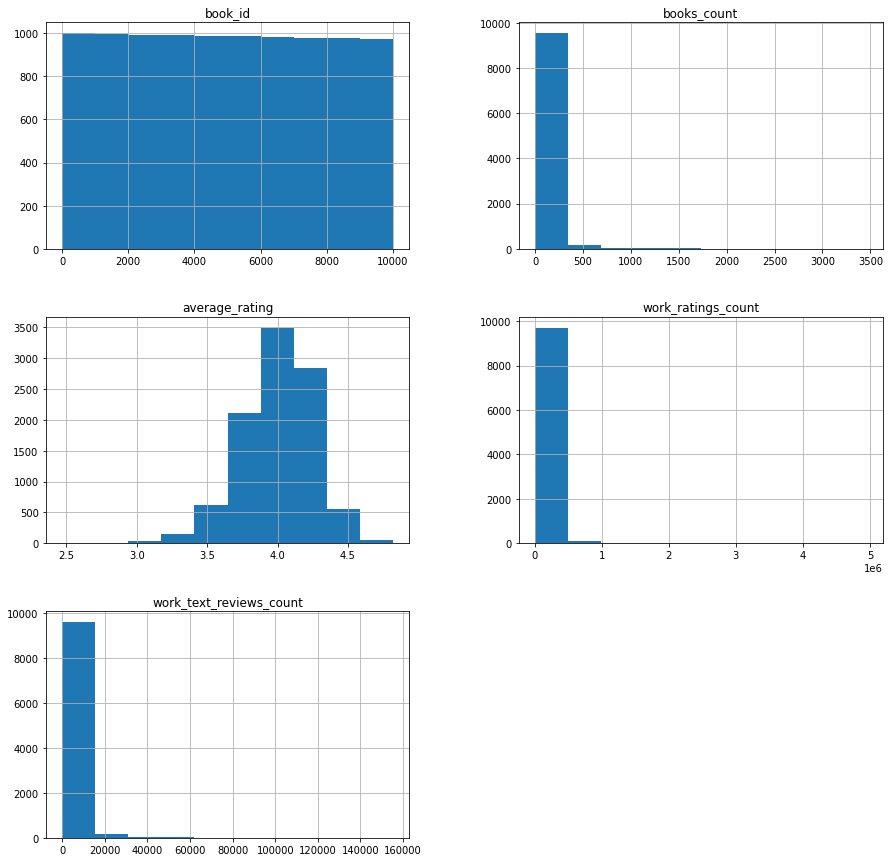

In [ ]:
#Distribution of dataframe Books
books.hist(figsize=(15,15))
plt.show()

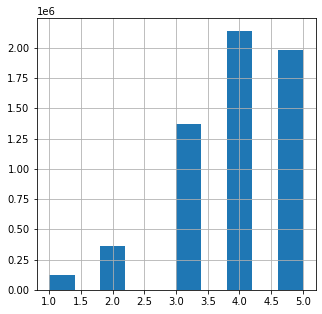

In [ ]:
#Rating Distribution
user_ratings['rating'].hist(figsize=(5,5))
plt.show()

- Most books have 4 rating score

**No. of Ratings Density Plot**

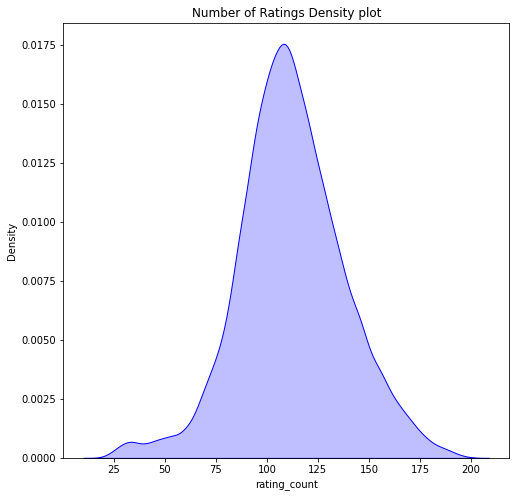

In [ ]:
user_rating_summary=user_ratings[['user_id', 'rating']].groupby(['user_id']).agg(['count'])
user_rating_summary.columns = ['_'.join(col) for col in user_rating_summary.columns.values]
user_rating_summary.reset_index(inplace=True)
plt.figure(figsize = (8, 8))
plt.title('Number of Ratings Density plot')
sns.kdeplot(user_rating_summary['rating_count'], color="blue", shade=True)
plt.show()

The density plot has a normal distribution , where bulk of the users have given 100-125 ratings.

### 1. Books

In [ ]:
counts = books.nunique()
print(counts)

book_id                      9858
books_count                   595
authors                      4613
original_publication_year     293
original_title               9798
language_code                  22
average_rating                184
work_ratings_count           8955
work_text_reviews_count      4567
image_url                    6569
dtype: int64


In [ ]:
print("The numbers of unique book is", counts['original_title'])

The numbers of unique book is 9798


1.1. The highest rated books

In [ ]:
asc_ranks = books.sort_values('average_rating', ascending= True)
fig1 = px.bar(asc_ranks.tail(10), x="average_rating", y="original_title", hover_data=['authors',	'original_publication_year'],
             color ='average_rating', labels={'average_rating':'Average Rating','original_title':'Original Title', 
             'authors':'Authors', 'original_publication_year':'Year Of Publication'}, title = 'Top 10 Highest Rated Books and Their Ratings',
             range_x=(0,5), orientation='h', width=1000, height=700)
fig1.update_layout(font=dict(size=15))
fig1.show()

1.2. The lowest rated books

In [ ]:
desc_ranks = books.sort_values('average_rating', ascending= False)
fig2 = px.bar(desc_ranks.tail(10), x="average_rating", y="original_title", hover_data=['authors',	'original_publication_year'],
             color ='average_rating', labels={'average_rating':'Average Rating','original_title':'Original Title', 
             'authors':'Authors', 'original_publication_year':'Year Of Publication'}, title = 'Top 10 Lowest Rated Books and Their Ratings',
             range_x=(0,5), orientation='h', width=1000, height=700)
fig2.update_layout(font=dict(size=18))
fig2.show()

1.3. Popular Books by Rating Counts

In [ ]:
top_popular = books.sort_values('work_ratings_count', ascending=False)
fifty_top_popular = top_popular[:50]
fig3 = px.treemap(fifty_top_popular, path =['original_title'], values='work_ratings_count', title='Top 50 Popular Books By Rating Counts', width=1200, height=1000)
fig3.update_layout(font=dict(size=20))
fig3.show()

### 2. Authors

In [ ]:
print("The numbers of unique author is", counts['authors'])

The numbers of unique author is 4613


2.1. Which author has published the most books?

In [ ]:
books_counts = books['authors'].value_counts().reset_index()
books_counts.columns = ['value', 'count']
books_counts = books_counts.sort_values(by='count', ascending= False)
fig4 = px.bar(books_counts.head(25), x="value", y="count", labels={'value':'Authors','count':'Numbers of Books'},
             title='Top 25 Authors That Published The Most Books', color='count', width=1000, height=700)
fig4.update_layout(font=dict(size=20))
fig4.show()

We count numbers of books written by each author then sort by numbers of books in ascending order. After that, we draw a histogram for 25 authors that the most book. With 57 books, Stephen King has published the most book. Following by Nora Roberts and Dean Koontz with 55 and 43 books, respectively 

2.2. Most popular authors by rating counts

In [ ]:
fifty_top_authors = asc_ranks.tail(50)
fig = px.treemap(fifty_top_authors, path=['authors'], values='average_rating',title='Top 50 Popular Authorsby Rating Counts', width=1000, height=700)
fig.show()

### 3. Publication

In [ ]:
print("The numbers of year of publication of the dataset is", counts['original_publication_year'])
print("The numbers of languague of the dataset is", counts['language_code'])

The numbers of year of publication of the dataset is 293
The numbers of languague of the dataset is 22


3.1. Top Years and Languages of Publication

In [ ]:
#Years of Publication
years = books['original_publication_year'].value_counts().reset_index()
years.columns = ['Years', 'Number of Books']
years= years.sort_values(by='Number of Books', ascending= False).head(25)
#Language of publication
languages= books['language_code'].value_counts().reset_index()
languages.columns = ['Languages', 'Number of Books']
#Remove cells that have language code is empty
languages= languages[languages['Languages'].astype(bool)] 
languages= languages.sort_values(by='Number of Books', ascending= False).head(5)
# Plotting bar chart
fig = make_subplots(rows=1, cols=2,
                subplot_titles=("Top Years of Publication","Top 5 Languages of Publication"), 
                specs=[[{"type": "bar"}, {"type": "pie"}]])

fig.add_trace(go.Bar(x=years['Years'], y=years['Number of Books'],
                marker=dict(color=years['Number of Books'])), 1, 1)

fig.add_trace(go.Pie(labels=languages['Languages'], values=languages['Number of Books'],textinfo='label+percent'), 1, 2)

fig.update_layout(showlegend= False,yaxis = dict(title="Number of Books"), width=1000, height=700)
fig.show()

### 4. Wordclouds

4.1. Wordclouds of Authors

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


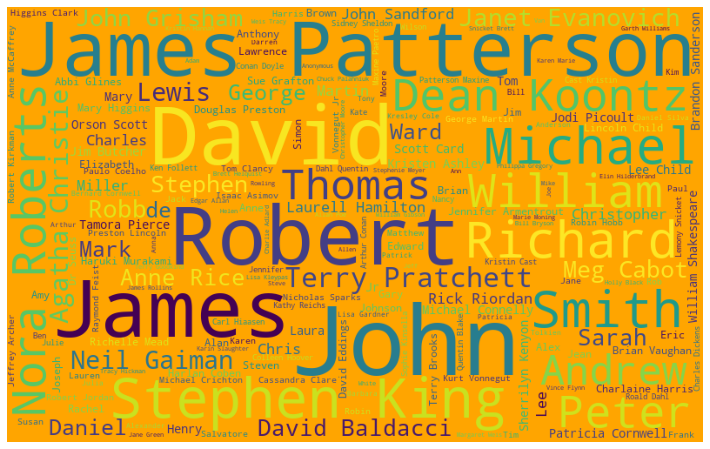

In [ ]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
author_string = " ".join(books['authors'])
wc1 = WordCloud(width=800,height=500,background_color="orange", mask=None,random_state=21, max_font_size=110,stopwords=stop_words).generate(author_string)
fig=plt.figure(figsize=(16,8))
plt.axis('off')
plt.imshow(wc1)

4.2. Wordclouds of Titles

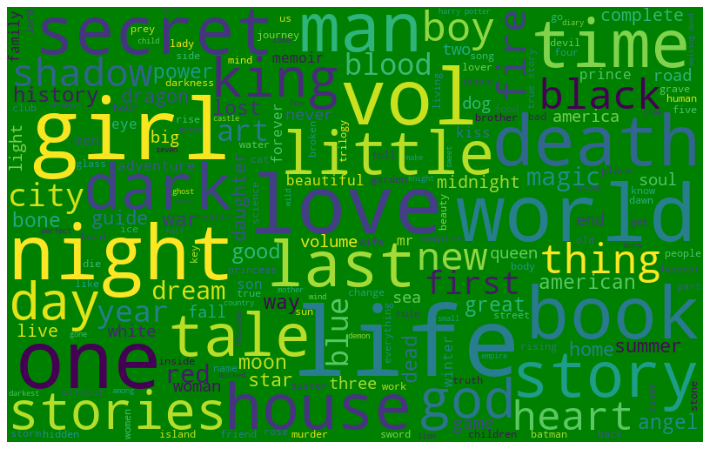

In [ ]:
title_string = " ".join(books['original_title'])
wc2 = WordCloud(width=800,height=500,background_color="green", mask=None,random_state=21, max_font_size=110,stopwords=stop_words).generate(title_string)
fig=plt.figure(figsize=(16,8))
plt.axis('off')
plt.imshow(wc2)

From the Wordclouds of Titles, we saw that the title contains 'girl', 'death', 'night', 'love', 'world', 'secret', 'life'.... are the main topics. We now figure out the dispersion of these words in the corpus by the order of publication year


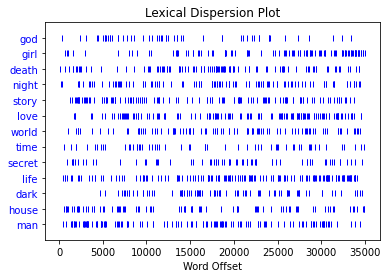

In [ ]:
#arrange title by the publication year
title= books[['original_title','original_publication_year']]
title= title.astype(str).sort_values(by='original_publication_year', ascending=True)
title= title['original_title'].to_string()
#Word dispersion plot for title
wordlist=nltk.word_tokenize(title)
wordlist= [i.lower() for i in wordlist if i.lower not in stop_words and i.isalpha()]
topics=['god','girl', 'death', 'night','story', 'love','world', 'time','secret', 'life','dark','house', 'man']
dispersion_plot(wordlist, topics) 
#we can tell that the topic "girl", "love","life" are covered more recently

4.3. Wordclouds of Merge Data

Merge data is the combination of books data and user rating data on work_id attribute from books data.

In [ ]:
cross_author_string = " ".join(merge_data['authors'].astype(str))
cross_title_string = " ".join(merge_data['original_title'].astype(str))

In [ ]:
def wordcloud(string):
    wc = WordCloud(width=800,height=500,mask=None,random_state=21, max_font_size=110,stopwords=stop_words).generate(string)
    fig=plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(wc)

**Wordcloud of cross_author_string**

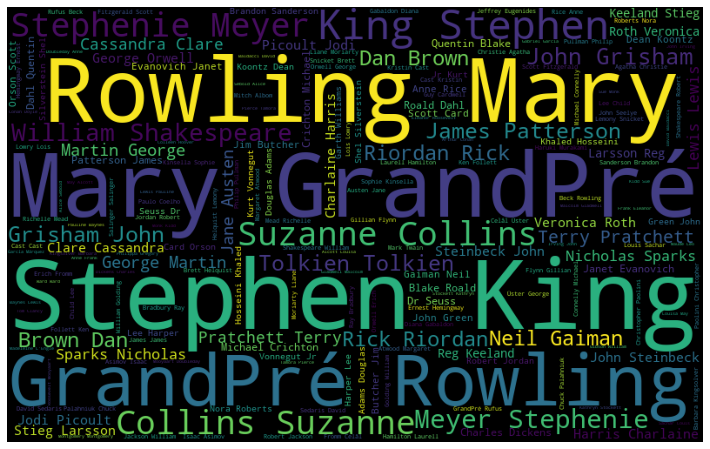

In [ ]:
wordcloud(cross_author_string)

**Wordcloud of cross_title_string**

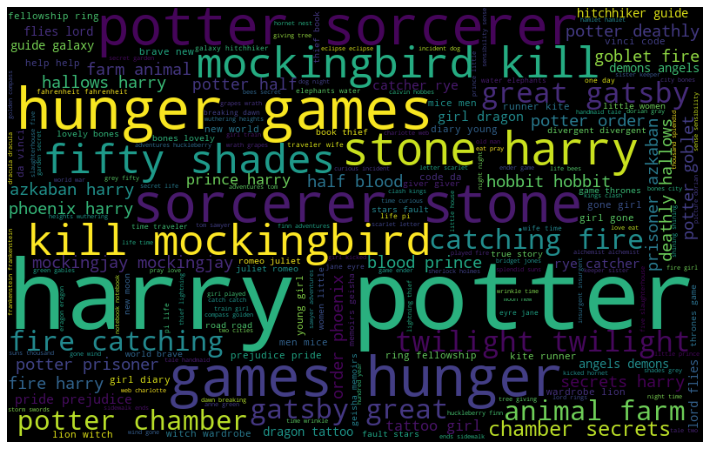

In [ ]:
wordcloud(cross_title_string)

In [ ]:
rating_counts = pd.DataFrame(merge_data['original_title'].value_counts())

## Build the Model

In [ ]:
rating_counts = pd.DataFrame(merge_data['original_title'].value_counts())
rating_counts.describe()

,original_title
count,9798.000000
mean,606.641764
std,1279.512742
min,8.000000
25%,156.000000
50%,250.000000
75%,517.000000
max,22806.000000


In [ ]:
def Basic(min_rating):
  rating_counts = pd.DataFrame(merge_data['original_title'].value_counts())
  low_reviewed_books= rating_counts[rating_counts['original_title'] <= min_rating].index
  common_books = merge_data[~merge_data['original_title'].isin(low_reviewed_books)]
  return (low_reviewed_books, common_books)

In [ ]:
def pivot_table(common_books):
  user_book_df = common_books.pivot_table(index=['user_id'],
                                        columns=['original_title'],
                                        values='user_rating',fill_value=0)
  return user_book_df

### **1. Content-Based Filtering**

In [ ]:
def similarity(common_books, book_title):
  common_books = common_books.drop_duplicates(subset=['original_title'])
  common_books.reset_index(inplace= True)
  common_books['index'] = [i for i in range(common_books.shape[0])]
  targeted_columns = ['original_title','authors','language_code']
  common_books['combined_features'] = [' '.join(common_books[targeted_columns].iloc[i,].values) for i in range(common_books[targeted_columns].shape[0])]
  cv = CountVectorizer()
  matrix = cv.fit_transform(common_books['combined_features'])
  cos_sim = cosine_similarity(matrix)
  index = common_books[common_books['original_title'] == book_title]['index'].values[0]
  similar_books = list(enumerate(cos_sim[index]))
  sorted_similar_books = sorted(similar_books,key=lambda x:x[1],reverse=True)[1:6]
  return(sorted_similar_books,common_books)


In [ ]:
def content_based_recommender(book_title):
    book_title = str(book_title).lower().strip()
    if book_title in merge_data['original_title'].values:
      low_reviewed_books, common_books =Basic(250)
        
      if book_title in low_reviewed_books:
          
          random_recommendation = pd.Series(common_books['original_title'].unique()).sample(5).values
          print('There are no recommendations for this book')
          print('Try: \n')
          for random in range(len(random_recommendation)):
            print(random+1,"-> ",random_recommendation[random].title())
  
      else:
          sorted_similar_books,common_books= similarity(common_books, book_title)
      
          books = []
          for i in range(len(sorted_similar_books)):
              books.append(common_books[common_books['index'] == sorted_similar_books[i][0]]['original_title'].item())
          print(books)
          fig, axs = plt.subplots(1,5,figsize=(18,5))
          fig.suptitle('Top 5 Books recommended by using content based recommender', size = 25)
          for i in range(len(books)):
      
              url = common_books.loc[common_books['original_title'] == books[i],'image_url'][:1].values[0]
              im = Image.open(requests.get(url, stream=True).raw)
              axs[i].imshow(im)
              axs[i].axis("off")
              axs[i].set_title('Rating: {}\n{}'.format(round(merge_data[merge_data['original_title'] == books[i]]['user_rating'].mean(),1),books[i].title()),
                            y=-0.18,
                                color="red",
                                fontsize=16)
              fig.show()
                     
    else:
        
        print('Cant find book in dataset, please check spelling')

['macbeth', 'othello', 'the merchant of venice', 'king lear', 'the tempest']


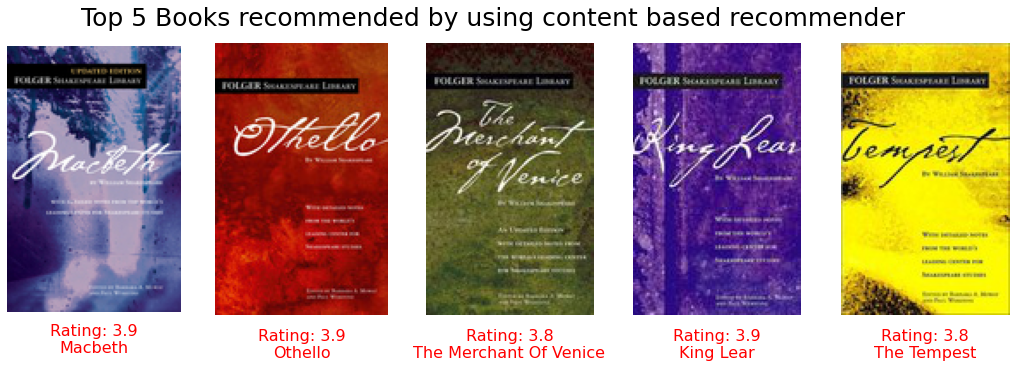

In [ ]:
content_based_recommender("romeo and juliet")

### **2. Item-Based Collaborative filtering**

In [ ]:
def item_based_recommender(book_title):
    
    book_title = str(book_title).lower().strip()
    if book_title in merge_data['original_title'].values:
      low_reviewed_books, common_books=Basic(2500)
        
      if book_title in low_reviewed_books:
          
          random_recommendation = pd.Series(common_books['original_title'].unique()).sample(5).values
          print('There are no recommendations for this book')
          print('Try:')
          for random in range(len(random_recommendation)):
            print(random+1,"-> ",random_recommendation[random].title())
      
      else:
          user_book_df = pivot_table(common_books)
      
          book = user_book_df[book_title]
          recom_data = pd.DataFrame(user_book_df.corrwith(book).sort_values(ascending=False)).reset_index(drop=False)
          
          if book_title in [book for book in recom_data['original_title']]:
              recom_data = recom_data.drop(recom_data[recom_data['original_title'] == book_title].index[0])
              
          low_rating = []
          for i in recom_data['original_title']:
              if merge_data[merge_data['original_title'] == i]['user_rating'].mean() < 4:
                  low_rating.append(i)
                  
          if recom_data.shape[0] - len(low_rating) > 5:
              recom_data = recom_data[~recom_data['original_title'].isin(low_rating)]
          
          recommend_data = recom_data[0:5]    
          recommend_data.columns = ['book_title','corr']
          
          fig, axs = plt.subplots(1, 5,figsize=(18,5))
          fig.suptitle('You may also like these books', size = 22)
          for i in range(len(recommend_data['book_title'].tolist())):
              url = merge_data.loc[merge_data['original_title'] == recommend_data['book_title'].tolist()[i],'image_url'][:1].values[0]
              im = Image.open(requests.get(url, stream=True).raw)
              axs[i].imshow(im)
              axs[i].axis("off")
              axs[i].set_title('Rating: {}\n{}'.format(round(merge_data[merge_data['original_title'] == recommend_data['book_title'].tolist()[i]]['user_rating'].mean(),1),recommend_data.book_title.tolist()[i].title()),
                            y=-0.18,
                                color="red",  
                                fontsize=16)
              fig.show()
    else:
        print('Cant find book in dataset, please check spelling')

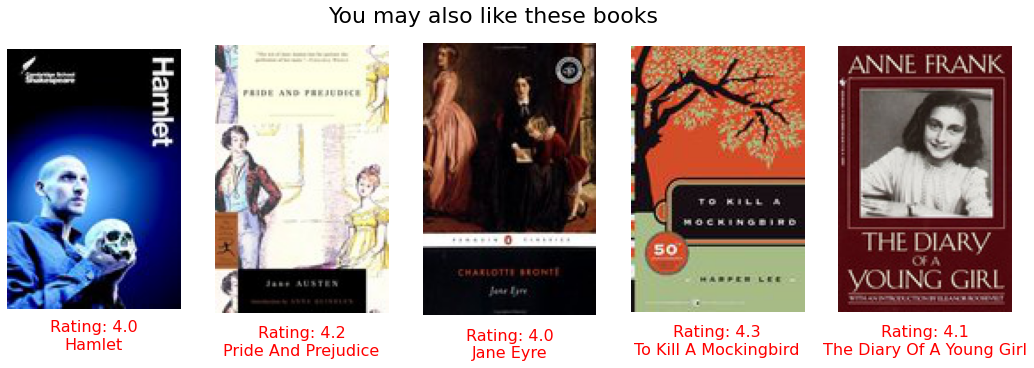

In [ ]:
item_based_recommender("Romeo and juliet")

### **3. User based collaborative filtering**

**Pick a random user: 226. Now let's check user 226 information**

In [ ]:
import random
current_user = 226
#or you can choose a random user id by using "random.choice(merge_data['user_id'].tolist())""
print('Pick user_id:',current_user)
#print(random)

Pick user_id: 226


In [ ]:
#get information of user 226
user226=merge_data.loc[merge_data.user_id == current_user]
user226=user226[['book_id','original_title','user_rating']].reset_index()
#rank from highest user rating to lowest user rating
user226=user226.sort_values(by='user_rating', ascending= False)
user226

,index,book_id,original_title,user_rating
64,2982003,881,the man who mistook his wife for a hat and oth...,5
97,4455557,2931,flatland: a romance of many dimensions,5
48,2313996,483,franny and zooey,5
99,4468695,2960,the poetry of robert frost,5
61,2924519,839,the merchant of venice,5
...,...,...,...,...
94,4252942,2491,heretics of dune,1
71,3244660,1102,dry,1
43,2127824,400,neuromancer,1
2,152095,10,pride and prejudice,1


In [ ]:
#visualize User 226 top 5 highest rated books
fig = px.bar(user226.head(5), x="user_rating", y="original_title", title = 'Top 5 books rated by user 226',
             range_x=(0,5),  labels={'user_rating':'User Rating','original_title':'Original Title'},
              color= "original_title", width=1000, height=700)
fig.show()

#### **3.1. Model Based User Recommendation system**




In [ ]:
min_rating = 1000
low_reviewed_books, common_books =Basic(min_rating)

In [ ]:
new_Books= merge_data[['user_id','book_id', 'user_rating']]
new_Books.head()

,user_id,book_id,user_rating
0,9,1,4
15209,36719,1,4
15208,36718,1,4
15207,36715,1,5
15206,36709,1,4


In [ ]:
book_considered=common_books[['user_id','book_id', 'user_rating']]
book_considered.head()

,user_id,book_id,user_rating
0,9,1,4
15209,36719,1,4
15208,36718,1,4
15207,36715,1,5
15206,36709,1,4


In [ ]:
from surprise import NMF, SVD, SVDpp, CoClustering
from surprise.model_selection import cross_validate
from surprise import Reader, Dataset

In [ ]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(book_considered, reader)

In [ ]:
# get the list of the movie ids
unique_ids = book_considered['book_id'].unique()
# get the list of the ids that the userid 226 has rated
iids226 = book_considered.loc[book_considered['user_id']==current_user, 'book_id']
# remove the rated movies for the recommendations
movies_to_predict = np.setdiff1d(unique_ids,iids226)

In [ ]:
iids226.head()

22885      2
108589     7
152095    10
204718    14
219001    15
Name: book_id, dtype: int64

In [ ]:
def book_names(pd):
  books_name=[]
  for id in pd["book_id"]:
    books_name.append(list(books.loc[books['book_id']==id, 'original_title'])[0])

  return(books_name)

##### **3.1.1 Matrix Factorization-based algorithms**


1.   NMF
2.   SDV
3.   SVD++


#Caution: Algorithms takes too long to run

###### **a. NMF**

In [ ]:
algo = NMF()
start1=time.time()
algo.fit(data.build_full_trainset())
my_recs1 = []
for iid in movies_to_predict:
    my_recs1.append((iid, algo.predict(uid=current_user,iid=iid).est))
end1=time.time()   
    
pd1=pd.DataFrame(my_recs1, columns=['book_id', 'predictions']).sort_values('predictions', ascending=False).head()



In [ ]:
pd1["book_title"]=book_names(pd1)

In [ ]:
pd1

,book_id,predictions,book_title
1065,1342,4.342223,night watch
423,472,4.304940,man's search for meaning
270,307,4.197798,the wise man's fear
450,504,4.153535,redeeming love
18,31,4.130878,the help


###### **b. SDV**

In [ ]:
algo = SVD()
start2=time.time()
algo.fit(data.build_full_trainset())
my_recs2 = []
for iid in movies_to_predict:
    my_recs2.append((iid, algo.predict(uid=current_user,iid=iid).est))
end2=time.time()
    
pd2=pd.DataFrame(my_recs2, columns=['book_id', 'predictions']).sort_values('predictions', ascending=False).head()
pd2["book_title"]=book_names(pd2)

In [ ]:
pd2

,book_id,predictions,book_title
719,804,4.468714,the tempest
398,444,4.435414,winnie-the-pooh
878,1010,4.396914,the essential calvin and hobbes: a calvin and ...
127,154,4.371356,macbeth
535,597,4.359295,don quixote


###### **c. SVD++**

In [ ]:
algo = SVDpp()
start3=time.time()
algo.fit(data.build_full_trainset())
my_recs3 = []
for iid in movies_to_predict:
    my_recs3.append((iid, algo.predict(uid=current_user,iid=iid).est))
end3=time.time()    
pd3=pd.DataFrame(my_recs3, columns=['book_id', 'predictions']).sort_values('predictions', ascending=False).head()
pd3['book_title']=book_names(pd3)

In [ ]:
pd3

,book_id,predictions,book_title
100,125,4.518338,hamlet
419,467,4.466048,the brief wondrous life of oscar wao
127,154,4.415157,macbeth
499,555,4.400986,"hamlet: screenplay, introduction and film diary"
433,485,4.371794,the brothers karamazov


##### **3.1.2. CoClustering**

In [ ]:
algo = CoClustering()
start4=time.time()
algo.fit(data.build_full_trainset())
my_recs5 = []
for iid in movies_to_predict:
    my_recs5.append((iid, algo.predict(uid=current_user,iid=iid).est))
time4=time.time()    
pd5=pd.DataFrame(my_recs5, columns=['book_id', 'predictions']).sort_values('predictions', ascending=False).head()
pd5["book_title"]=book_names(pd5)
pd5

,book_id,predictions,book_title
1036,1264,4.235295,queen of shadows
161,192,4.175312,the name of the wind
888,1022,4.156207,heir of fire
764,862,4.149593,words of radiance
853,976,4.144712,"dr. seuss's green eggs and ham: for soprano, b..."


In [ ]:
#These Methods take lot of time so we have created our own recommendation system

In [ ]:
cv = []
# Iterate over all recommender system algorithms
for recsys in [NMF(), SVD(), SVDpp(), CoClustering()]:
    # Perform cross validation
    tmp = cross_validate(recsys, data, measures=['RMSE'], cv=3, verbose=False)
    cv.append((str(recsys).split(' ')[0].split('.')[-1], tmp['test_rmse'].mean()))
evaluation=pd.DataFrame(cv, columns=['Recommendation_System', 'RMSE'])

In [ ]:
evaluation

,Recommendation_System,RMSE
0,NMF,0.892352
1,SVD,0.858328
2,SVDpp,0.843614
3,CoClustering,0.890359


In [ ]:
model_based= pd.DataFrame()
model_based['NMF'] = pd1["book_title"].tolist()
model_based['SDV'] = pd2["book_title"].tolist()
model_based['SVD++'] = pd3["book_title"].tolist()
model_based['CoClustering'] = pd5["book_title"].tolist()

model_based

,NMF,SDV,SVD++,CoClustering
0,night watch,the tempest,hamlet,queen of shadows
1,man's search for meaning,winnie-the-pooh,the brief wondrous life of oscar wao,the name of the wind
2,the wise man's fear,the essential calvin and hobbes: a calvin and ...,macbeth,heir of fire
3,redeeming love,macbeth,"hamlet: screenplay, introduction and film diary",words of radiance
4,the help,don quixote,the brothers karamazov,"dr. seuss's green eggs and ham: for soprano, b..."


#### **Visualize the best performing model in Model Based User Recommendation System (SVD++)**

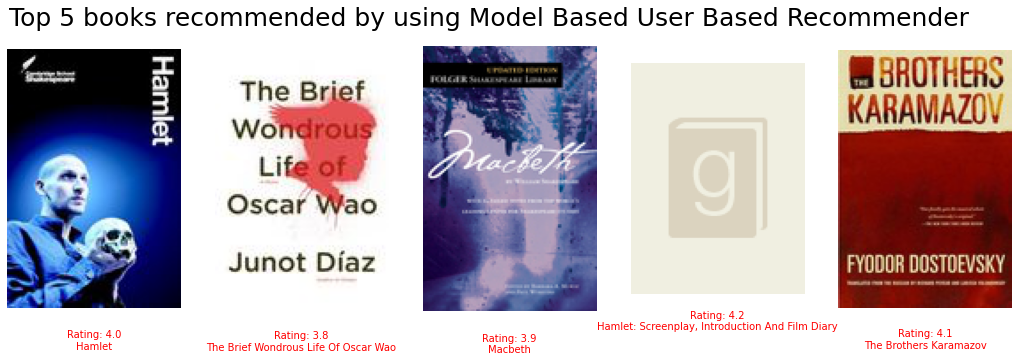

In [ ]:
fig, axs = plt.subplots(1,5,figsize=(18,5))
fig.suptitle('Top 5 books recommended by using Model Based User Based Recommender ', size = 25)
for i in range(len(pd3['book_id'])):
        url = merge_data.loc[merge_data['book_id'] == pd3['book_id'].tolist()[i],'image_url'][:1].values[0]
        im = Image.open(requests.get(url, stream=True).raw)
        axs[i].imshow(im)
        axs[i].axis("off")
        axs[i].set_title('Rating: {}\n{}'.format(round(merge_data[merge_data['book_id'] == pd3['book_id'].tolist()[i]]['user_rating'].mean(),1),pd3.book_title.tolist()[i].title()),
                            y=-0.18,
                                color="red",  
                                fontsize=10)
        fig.show()

#### **3.2. Memory-Based User Recommendation System**

**Step 1: Pick a random user.**

In [ ]:
current_user = 226

In [ ]:
min_rating = 1000
low_reviewed_books, common_books =Basic(min_rating)

In [ ]:
user_book_df = pivot_table(common_books)

**Step 2: Write a function to find the 3 most similar users to the current_user using cosine similarity**

In [ ]:
import operator
def similar_users(user_id, matrix, k=3):
    # create a df of just the current user
    user = matrix[matrix.index == user_id]
    
    # and a df of all other users
    other_users = matrix[matrix.index != user_id]
    
    # calc cosine similarity between user and each other user
    similarities = cosine_similarity(user,other_users)[0].tolist()
    
    # create list of indices of these users
    indices = other_users.index.tolist()
    
    # create key/values pairs of user index and their similarity
    index_similarity = dict(zip(indices, similarities))
    
    # sort by similarity
    index_similarity_sorted = sorted(index_similarity.items(), key=operator.itemgetter(1))
    index_similarity_sorted.reverse()
    df = pd.DataFrame(index_similarity_sorted)
    df.columns= ['User ID', 'Cosine Similarity']
    
    # grab k users off the top
    top_users_similarities = index_similarity_sorted[:k]
    users = [u[0] for u in top_users_similarities]
    
    return users

**Step 3: Recommend top 5 books for the random user**

In [ ]:
def user_based_recommender(user_index, similar_user_indices, matrix, items=5):
  if user_index  in (merge_data['user_id'].unique()):
    # load vectors for similar users
    similar_users = matrix[matrix.index.isin(similar_user_indices)]
    # calc avg ratings across the 3 similar users
    similar_users = similar_users.mean(axis=0)
    # convert to dataframe so its easy to sort and filter
    similar_users_df = pd.DataFrame(similar_users, columns=['mean'])
    
    
    # load vector for the current user
    user_df = matrix[matrix.index == user_index]
    # transpose it so its easier to filter
    user_df_transposed = user_df.transpose()
    # rename the column as 'rating'
    user_df_transposed.columns = ['rating']
    # remove any rows without a 0 value. Book not read yet
    user_df_transposed = user_df_transposed[user_df_transposed['rating']==0]
    # generate a list of books the user has not read
    books_unseen = user_df_transposed.index.tolist()
    
    # filter avg ratings of similar users for only book the current user has not read
    similar_users_df_filtered = similar_users_df[similar_users_df.index.isin(books_unseen)]
    # order the dataframe
    similar_users_df_ordered = similar_users_df.sort_values(by=['mean'], ascending=False)
    # grab the top n book   
    top_n_book = similar_users_df_ordered.head(items)
    top_n_book = top_n_book.reset_index(level=['original_title'])
    print(top_n_book['original_title'].tolist())
    fig, axs = plt.subplots(1,5,figsize=(18,5))
    fig.suptitle('Top 5 books recommended by using user based recommender(memory-based) ', size = 25)
    for i in range(len(top_n_book['original_title'])):
        url = merge_data.loc[merge_data['original_title'] == top_n_book['original_title'].tolist()[i],'image_url'][:1].values[0]
        im = Image.open(requests.get(url, stream=True).raw)
        axs[i].imshow(im)
        axs[i].axis("off")
        axs[i].set_title('Rating: {}\n{}'.format(round(merge_data[merge_data['original_title'] == top_n_book['original_title'].tolist()[i]]['user_rating'].mean(),1),top_n_book.original_title.tolist()[i].title()),
                            y=-0.18,
                                color="red",  
                                fontsize=10)
        fig.show()
  else:
    random_recommendation = pd.Series(merge_data['original_title'].unique()).sample(5).values
    print('No user history. Please create an account for better recommendation.')
    print('Try:')
    for random in range(len(random_recommendation)):
      print(random+1,"-> ",random_recommendation[random].title())

Top 3 similar users are [1335, 4639, 458]
['harry potter and the order of the phoenix', 'king lear', "the hitchhiker's guide to the galaxy", 'the giver', 'macbeth']


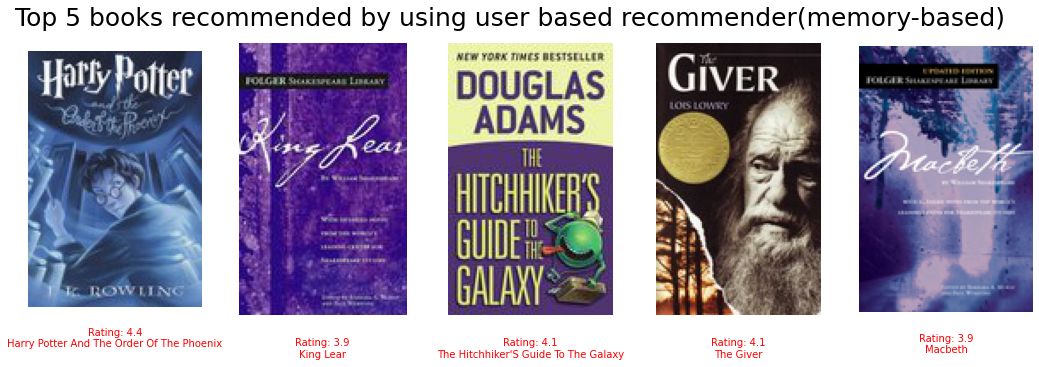

In [ ]:
# try it out
start5=time.time()
current_user = 226
similar_user_indices = similar_users(current_user, user_book_df)
print('Top 3 similar users are', similar_user_indices)
user_based_recommender(current_user, similar_user_indices, user_book_df)
end5=time.time()

# **Comparing time taken by each user based recommendation model**

In [ ]:
time_taken= pd.DataFrame({"Models":["NMF","SVD","SDV++","CoClustering","MemoryBasedURS"],"Time(sec) ":[end1-start1,end2-start2,end3-start3,time4-start4,end5-start5]})

In [ ]:
time_taken

,Models,Time(sec)
0,NMF,216.899351
1,SVD,179.383740
2,SDV++,2967.664472
3,CoClustering,105.434607
4,MemoryBasedURS,3.670540


In [ ]:
pd_compare=pd.DataFrame({"SVD++":['Hamlet', 'The Brief Wondrous Life of Oscar Wao','Macbeth','Hamlet: Screenplay, Introduction and Film Diary', 'The Brothers Karamazov'],"Memory-Based Model":['Harry Potter and the Order of the Phoenix', 'King Lear', "The Hitchhiker's Guide to the Galaxy", 'The Giver', 'Macbeth']})
pd_compare


,SVD++,Memory-Based Model
0,Hamlet,Harry Potter and the Order of the Phoenix
1,The Brief Wondrous Life of Oscar Wao,King Lear
2,Macbeth,The Hitchhiker's Guide to the Galaxy
3,"Hamlet: Screenplay, Introduction and Film Diary",The Giver
4,The Brothers Karamazov,Macbeth


###### **3.1.3. Collaborative filtering with Matrix Factorization Using Deep Learning**

In Collaborative Filtering, the model predicts the user's rating for a given book. Because of this, test and train sets can be created and root mean square error (RMSE) can be used to calculate the error rate of the model (difference between actual rating and predicted rating). The lower the RMSE, the lower the error and the more accurate the model.

*  Matrix Factorization is one of the most widely used ways of generating recommendations using low rank matrix factors.It involves decomposing a large matrix (usually a User-Item matrix in the context of recommendation system) into two smaller latent factor matrices.
*   The dot product of these two matrices approximates the already known ratings and can produce ratings for user-item combinations which had no values in the original matrix.



In [ ]:
book_user = merge_data[['user_id','book_id','original_title','user_rating']]
book_user =  book_user.sort_values('user_id', ascending=True)
book_user.head()

,user_id,book_id,original_title,user_rating
1369081,1,171,emma,3
2177255,1,421,the paris wife,5
4604077,1,3294,those who leave and those who stay,5
1559499,1,216,the art of racing in the rain,3
568588,1,43,jane eyre,4


**Train-Test Split for Deep Learning Model**

In [ ]:
users = book_user.user_id.unique()
books = book_user.book_id.unique()

# user_id and book_id become dictionary elements with values ranging from 0 to max len 
userid2idx = {o:i for i,o in enumerate(users)}
bookid2idx = {o:i for i,o in enumerate(books)}

# Here we update the book_id and user_id so that they are contiguous integers, 
# which we want when using embeddings in deep learning model.
book_user['user_id'] = book_user['user_id'].apply(lambda x: userid2idx[x])
book_user['book_id'] = book_user['book_id'].apply(lambda x: bookid2idx[x])

Y=book_user['user_rating']
X=book_user.drop(['user_rating'],axis=1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape , X_test.shape, Y_train.shape, Y_test.shape)

(4755100, 3) (1188776, 3) (4755100,) (1188776,)


**Build the model**

In [ ]:
def build_model(dropout,latent_factors):
    # hyperparamters
    n_books=len(book_user['book_id'].unique())
    n_users=len(book_user['user_id'].unique())
    n_latent_factors=latent_factors  
    
    # Creating embedding layers
    user_input=Input(shape=(1,),name='user_input',dtype='int64')
    user_embedding=Embedding(input_dim=n_users, output_dim=n_latent_factors, name='user_embedding',
                             embeddings_initializer=tf.keras.initializers.GlorotUniform(seed=42))(user_input)
    user_vec =Flatten(name='FlattenUsers')(user_embedding)
    user_vec=Dropout(dropout)(user_vec)
    
    book_input=Input(shape=(1,),name='book_input',dtype='int64')
    book_embedding=Embedding(input_dim=n_books, output_dim=n_latent_factors, name='book_embedding',
                             embeddings_initializer=tf.keras.initializers.GlorotUniform(seed=42))(book_input)
    book_vec=Flatten(name='FlattenBooks')(book_embedding)
    book_vec=Dropout(dropout)(book_vec)
    
    # Get dot product of user and movie embeddings into a single vector, which we feed into the neural net.
    sim=dot([user_vec,book_vec],name='Similarity-Dot-Product',axes=1)
    
    nn_inp=Dense(128,activation='relu')(sim)
    nn_inp=Dropout(dropout)(nn_inp)
    nn_inp=Dense(64,activation='relu')(nn_inp)
    nn_inp=BatchNormalization()(nn_inp)
    nn_inp=Dense(1,activation='relu')(nn_inp)
    model =Model([user_input, book_input],nn_inp)
    return model

In [ ]:
model = build_model(0.4,65)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 book_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 65)        3472560     ['user_input[0][0]']             
                                                                                                  
 book_embedding (Embedding)     (None, 1, 65)        640770      ['book_input[0][0]']             
                                                                                              

**Fit the model**

In [ ]:
model.compile(optimizer=Adam(lr=1e-4),loss='mse')
batch_size=128
epochs=5
History = model.fit([X_train.user_id,X_train.book_id],Y_train, batch_size=batch_size,
                              epochs =epochs, validation_data = ([X_test.user_id,X_test.book_id],Y_test),
                              verbose = 1)

Epoch 1/5
37150/37150 [==============================] - 439s 12ms/step - loss: 0.9080 - val_loss: 0.8796
Epoch 2/5
37150/37150 [==============================] - 437s 12ms/step - loss: 0.8320 - val_loss: 0.8399
Epoch 3/5
37150/37150 [==============================] - 439s 12ms/step - loss: 0.7861 - val_loss: 0.8135
Epoch 4/5
37150/37150 [==============================] - 417s 11ms/step - loss: 0.7552 - val_loss: 0.8057
Epoch 5/5
 7563/37150 [=====>........................] - ETA: 5:15 - loss: 0.7258

In [ ]:
plt.plot(History.history['loss'] , 'g')
plt.plot(History.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

**Rating Prediction**

*   We can use the model to generate predictions by passing a pair of integers - a user id and a book id. The output will be a predicted rating.
*   Hight predicted rating means user would enjoy this particular book, low rating means user won't like the book.

In [ ]:
preds = model.predict([X_test.user_id,X_test.book_id])
pred_df = (preds,Y_test)
df_user_id = pd.DataFrame(np.array(X_test.user_id))
df_book_id = pd.DataFrame(np.array(X_test.book_id))
df_actual_rating = pd.DataFrame(np.array(Y_test))
df_preds = pd.DataFrame(preds)

dfList = [df_user_id, df_book_id,df_actual_rating,df_preds]  
pred_df = pd.concat(dfList,ignore_index=True,axis=1)

#new_df = pd.concat([new_df,df_preds],ignore_index=True,axis=1)
pred_df.rename(columns={ pred_df.columns[0]: "user_id" }, inplace = True)
pred_df.rename(columns={ pred_df.columns[1]: "book_id" }, inplace = True)
pred_df.rename(columns={ pred_df.columns[2]: "user_rating" }, inplace = True)
pred_df.rename(columns={ pred_df.columns[3]: "Pred_Rating" }, inplace = True)
pred_df

In [ ]:
pred_df.isna().sum()

**Compare the Predictions**

We will compare the overlap of recommendations of Top-10 predicted book and see how the recommender system performed as compared to actual Top-10.

We choose such a evaluation measure instead of other metrics like MAE to compare absolute ratings. Becuase in many large scale industrial recommender systems (Ex-Amazon etc.), from the point of deploying the recommendation, its always done in a way where a multiple books are shown at once (8-12 typically based on the UI). Thus in many practical applications, one is interested if the top-K (here k=10) overlap and as long as we can get maximum coverage, the relative order doesn't matter.

In [ ]:
##Function for checking overlap for one specific user
def check_overlap(UserId,top_recos_to_check):
    samp_user = pred_df[pred_df['user_id']==UserId][['user_id','user_rating','book_id']]
    samp_user.sort_values(by='user_rating', ascending=False, inplace=True)
    available_actual_ratings = samp_user.shape[0]
    rows_to_fetch = min(available_actual_ratings,top_recos_to_check)
    preds_df_sampuser = pred_df[pred_df['user_id']==UserId][['user_id','Pred_Rating','book_id']]
    preds_df_sampuser.sort_values(by='Pred_Rating', ascending=False, inplace=True)
    actual_rating = samp_user.iloc[0:rows_to_fetch,:]
    pred_rating = preds_df_sampuser.iloc[0:rows_to_fetch,:]
    overlap = pd.Series(list(set(actual_rating.book_id).intersection(set(pred_rating.book_id))))
    pct_overlap = (len(overlap)/rows_to_fetch)*100
    #print("Percentage of overlap in top"+str(top_recos_to_check)+" for User ID - "+str(UserId)+" : "+str(pct_overlap))
    return pct_overlap

In [ ]:
test_user_list = pred_df.user_id.unique().tolist()
overlap_summary={}
top_recos_to_check =10
for users in test_user_list:
    overlap_summary[users]= check_overlap(users,top_recos_to_check)

In [ ]:
sorted_summary = sorted(overlap_summary.items(), key=lambda x: x[1], reverse=True)
max_overlap = np.array(list(overlap_summary.values())).max()
min_overlap = np.array(list(overlap_summary.values())).min()
mean_overlap = np.array(list(overlap_summary.values())).mean()
print("Max overlap in top" +str(top_recos_to_check)+ " books "+str(max_overlap))
print("Min overlap in top "+str(top_recos_to_check)+ " books "+str(min_overlap))
print("Average overlap in top "+str(top_recos_to_check)+ " books "+str(mean_overlap))

Now we are able to recommend almost 2 out of 4 books correctly to the user.

Further improvments can be made by playing around with network architecture.

**Recommending top 5 books to random user**

In [ ]:
def recommendation(UserId,top_recos_to_check):

  if user_index  in (merge_data['user_id'].unique()):
    samp_user = pred_df[pred_df['user_id']==UserId][['user_id','book_id','user_rating','Pred_Rating']]
    samp_user.sort_values(by='Pred_Rating', ascending=False, inplace=True)
    
    # grab the top n book   
    top_books = samp_user.head(top_recos_to_check)
    top_n_book_list = top_books['book_id'].tolist()
    
    top_n_book_title = []
    column_names = list(merge_data.columns)
    for book in top_n_book_list:
      book_title = merge_data[merge_data['book_id'] == book].values[0]
      top_n_book_title.append(book_title)
  
    top_n_book = pd.DataFrame(top_n_book_title, columns = column_names)
    
    print(top_n_book['original_title'].tolist())
    fig, axs = plt.subplots(1,5,figsize=(18,5))
    fig.suptitle('Top 5 books recommended by using user based recommender ', size = 25)
    for i in range(len(top_n_book['original_title'])):
      url = merge_data.loc[merge_data['original_title'] == top_n_book['original_title'].tolist()[i],'image_url'][:1].values[0]
      im = Image.open(requests.get(url, stream=True).raw)
      axs[i].imshow(im)
      axs[i].axis("off")
      axs[i].set_title('Rating: {}\n{}'.format(round(merge_data[merge_data['original_title'] == top_n_book['original_title'].tolist()[i]]['user_rating'].mean(),1),top_n_book.original_title.tolist()[i].title()),
                            y=-0.18,
                                color="red",  
                                fontsize=16)
      fig.show()

  else:
    random_recommendation = pd.Series(merge_data['original_title'].unique()).sample(5).values
    print('No user history. Please create an account for better recommendation.')
    print('Try:')
    for random in range(len(random_recommendation)):
      print(random+1,"-> ",random_recommendation[random].title())
        

In [ ]:
# try it out
current_user = 226
top_recos_to_check =5
recommendation(current_user,top_recos_to_check)